Epoch 0 | Loss: 0.07648207
Epoch 10 | Loss: 0.03083069
Epoch 20 | Loss: 0.03106810
Epoch 30 | Loss: 0.03501480
Epoch 40 | Loss: 0.03300742


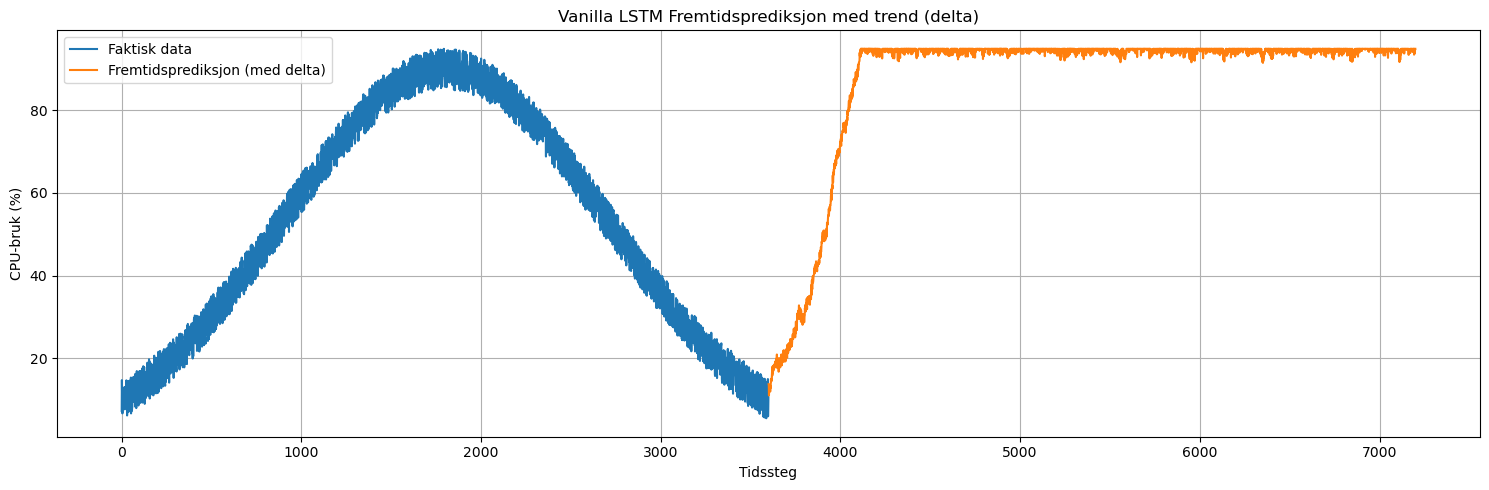

In [34]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# === Last inn datasett ===
df = pd.read_csv('/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/Newest addition/Gausian curve/gaussian_curve_fixed.csv')
data = df['Y'].values.reshape(-1, 1)

# === Normaliser verdier ===
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

# === Lag delta (differanse mellom punkter)
delta = np.diff(data_normalized, axis=0)
delta = np.vstack([[0], delta])  # legg til 0 først for å beholde lengde

# === Lag sekvenser med både verdi og delta ===
def create_sequences_with_delta(values, deltas, seq_length):
    xs, ys = [], []
    for i in range(len(values) - seq_length):
        val_seq = values[i:i+seq_length]
        delta_seq = deltas[i:i+seq_length]
        x = np.hstack([val_seq, delta_seq])  # kombiner verdier og delta
        y = values[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 90
X, y = create_sequences_with_delta(data_normalized, delta, seq_length)

# === Konverter til PyTorch ===
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# === Vanilla LSTM med 2 input-features (verdi + delta) ===
class LSTMModel(nn.Module):
    def __init__(self, input_size=2, hidden_layer_size=128, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.linear(lstm_out[:, -1, :])  # siste output
        return out

# === Initialiser modell ===
model = LSTMModel()
loss_function = nn.L1Loss()  # L1 gir ofte bedre trendfølsomhet
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# === Tren modellen ===
epochs = 50
for i in range(epochs):
    for seq, labels in dataloader:
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = loss_function(y_pred, labels)
        loss.backward()
        optimizer.step()

    if i % 10 == 0:
        print(f"Epoch {i} | Loss: {loss.item():.8f}")

# === Prediksjon frem i tid (3600 steg) ===
model.eval()
last_vals = data_normalized[-seq_length:]
last_deltas = delta[-seq_length:]
future_input = np.hstack([last_vals, last_deltas]).tolist()

noise_level = 0.01
future_preds = []

for i in range(3600):
    seq_input = torch.tensor(future_input[-seq_length:], dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        pred = model(seq_input).item()

    # Beregn delta og legg til neste punkt
    prev_val = future_input[-1][0]
    new_delta = pred - prev_val
    pred_with_noise = np.clip(pred + np.random.normal(0, noise_level), 0.0, 1.0)

    future_preds.append(pred_with_noise)
    future_input.append([pred_with_noise, new_delta])

# === Inverse transform for å få CPU % tilbake ===
real_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))
original_real = scaler.inverse_transform(data_normalized)

# === Plot ===
plt.figure(figsize=(15, 5))
plt.plot(original_real, label='Faktisk data')
plt.plot(range(len(original_real), len(original_real) + len(real_preds)), real_preds, label='Fremtidsprediksjon (med delta)')
plt.title("Vanilla LSTM Fremtidsprediksjon med trend (delta)")
plt.xlabel("Tidssteg")
plt.ylabel("CPU-bruk (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
